# Adversarial examples for boosted stumps and trees

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data
import utils
from classifiers import OneVsAllClassifier
from stump_ensemble import StumpEnsemble
from tree_ensemble import TreeEnsemble
from attacks import exact_attack_stumps, cube_attack, binary_search_attack

%matplotlib inline
sns.set(font_scale=1)
# sns.set_style("white")
np.set_printoptions(precision=6, suppress=True)



Model name: 2019-08-11 14:28:05 dataset=mnist_1_5 weak_learner=tree model=plain n_train=-1 n_trials_coord=784 eps=0.300 max_depth=4 lr=0.2
Best iter to take the model: 71
Ensemble of 72/150 trees restored: exps_diff_depth/2019-08-11 14:28:05 dataset=mnist_1_5 weak_learner=tree model=plain n_train=-1 n_trials_coord=784 eps=0.300 max_depth=4 lr=0.2.model.npy
iter_bs 0: yf=[ -6.756728  -9.250336  -6.845145  -6.649005 -10.368723  -8.868709
 -10.368723  -9.416708], eps=[1. 1. 1. 1. 1. 1. 1. 1.]
iter_bs 1: yf=[ -3.797247 -10.490554  -1.563872   0.176218 -11.853583 -12.051593
 -10.512027  -9.921702], eps=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
iter_bs 2: yf=[  1.30749   -9.728162   2.389437  -4.009847 -11.201712 -11.488387
 -11.59265  -10.490178], eps=[0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25]
iter_bs 3: yf=[ -2.590427  -9.026817  -0.784776  -1.687919 -11.569015 -10.718706
 -10.987304  -9.85365 ], eps=[0.375 0.125 0.375 0.625 0.125 0.125 0.125 0.125]
iter_bs 4: yf=[ -2.076866  -6.654438  -0.384776  

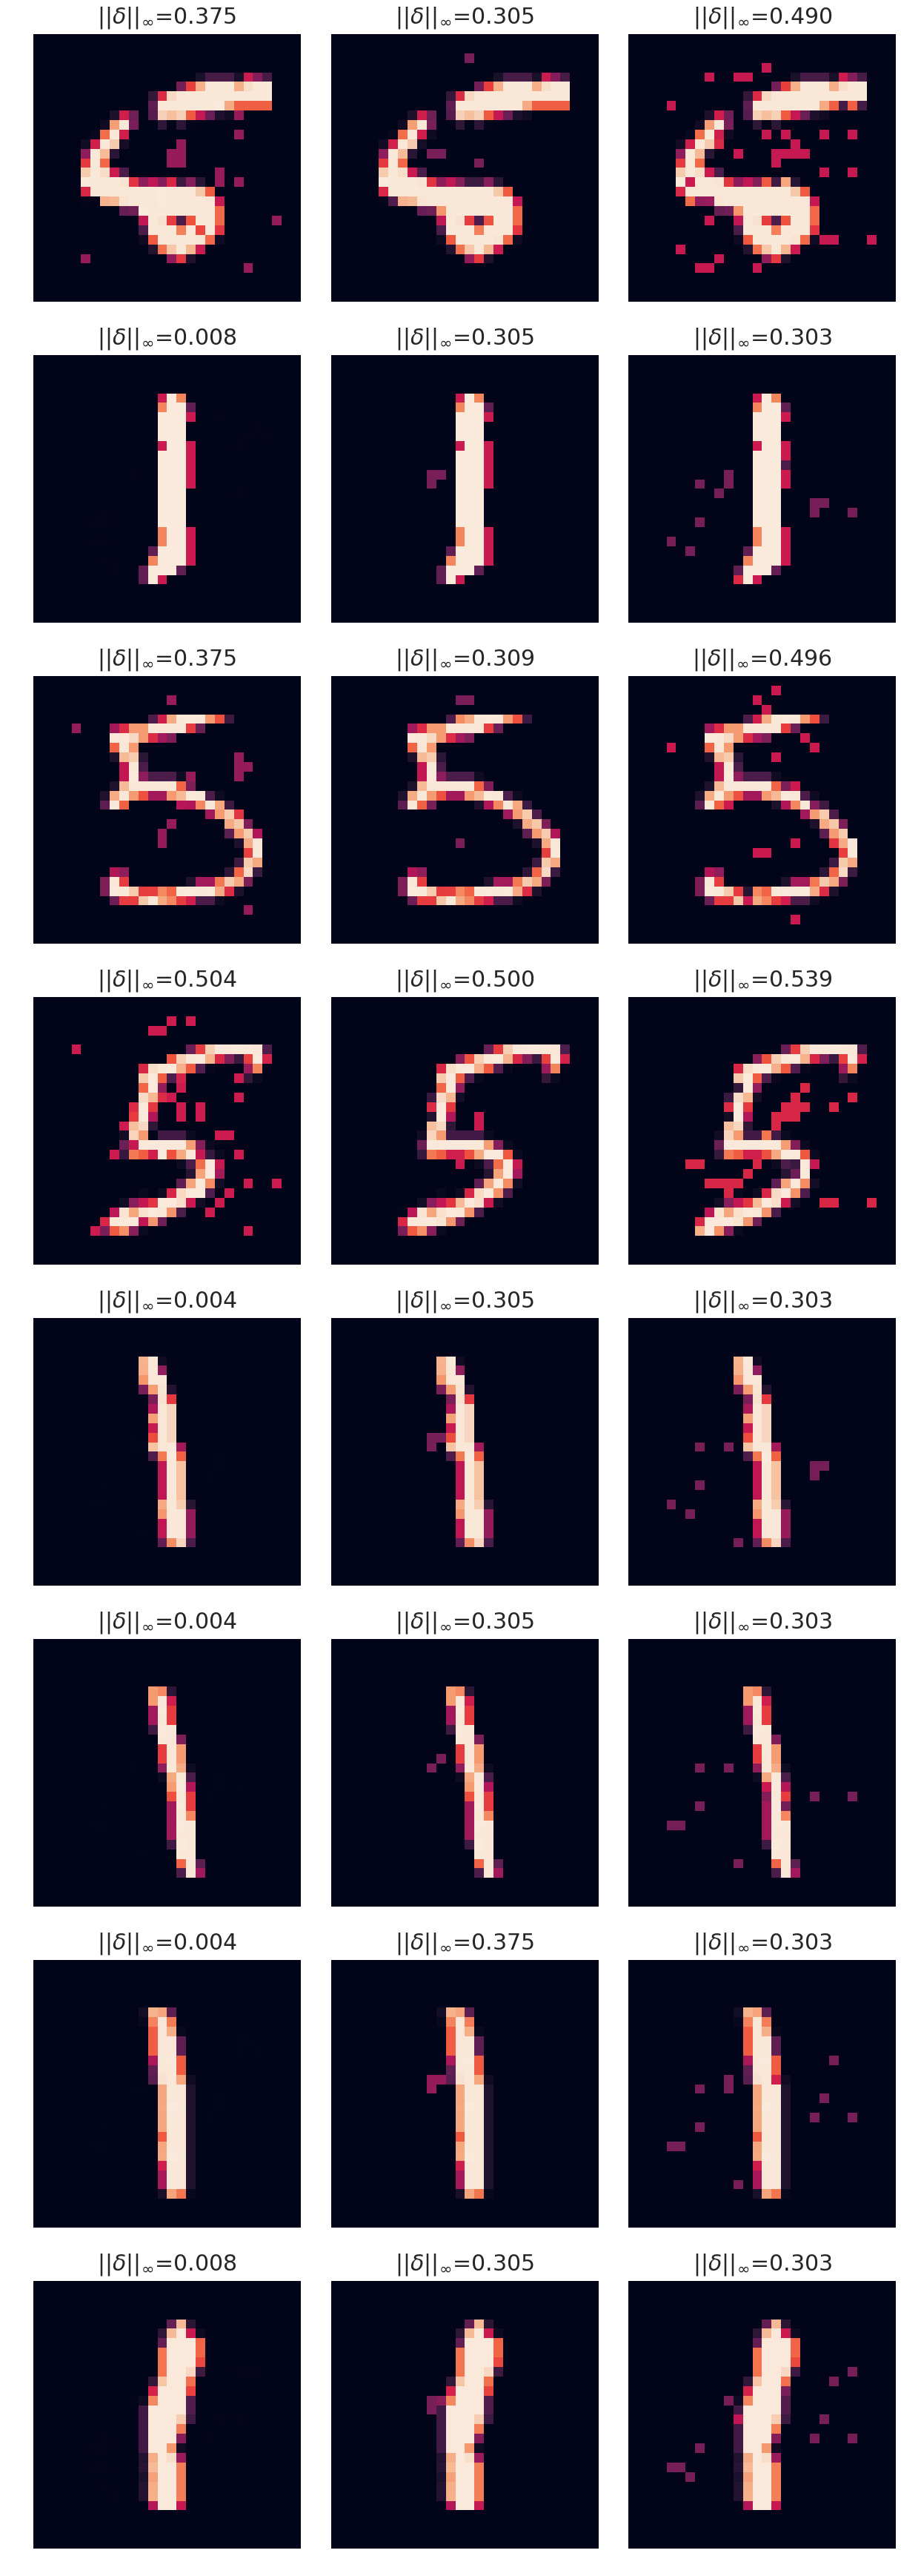

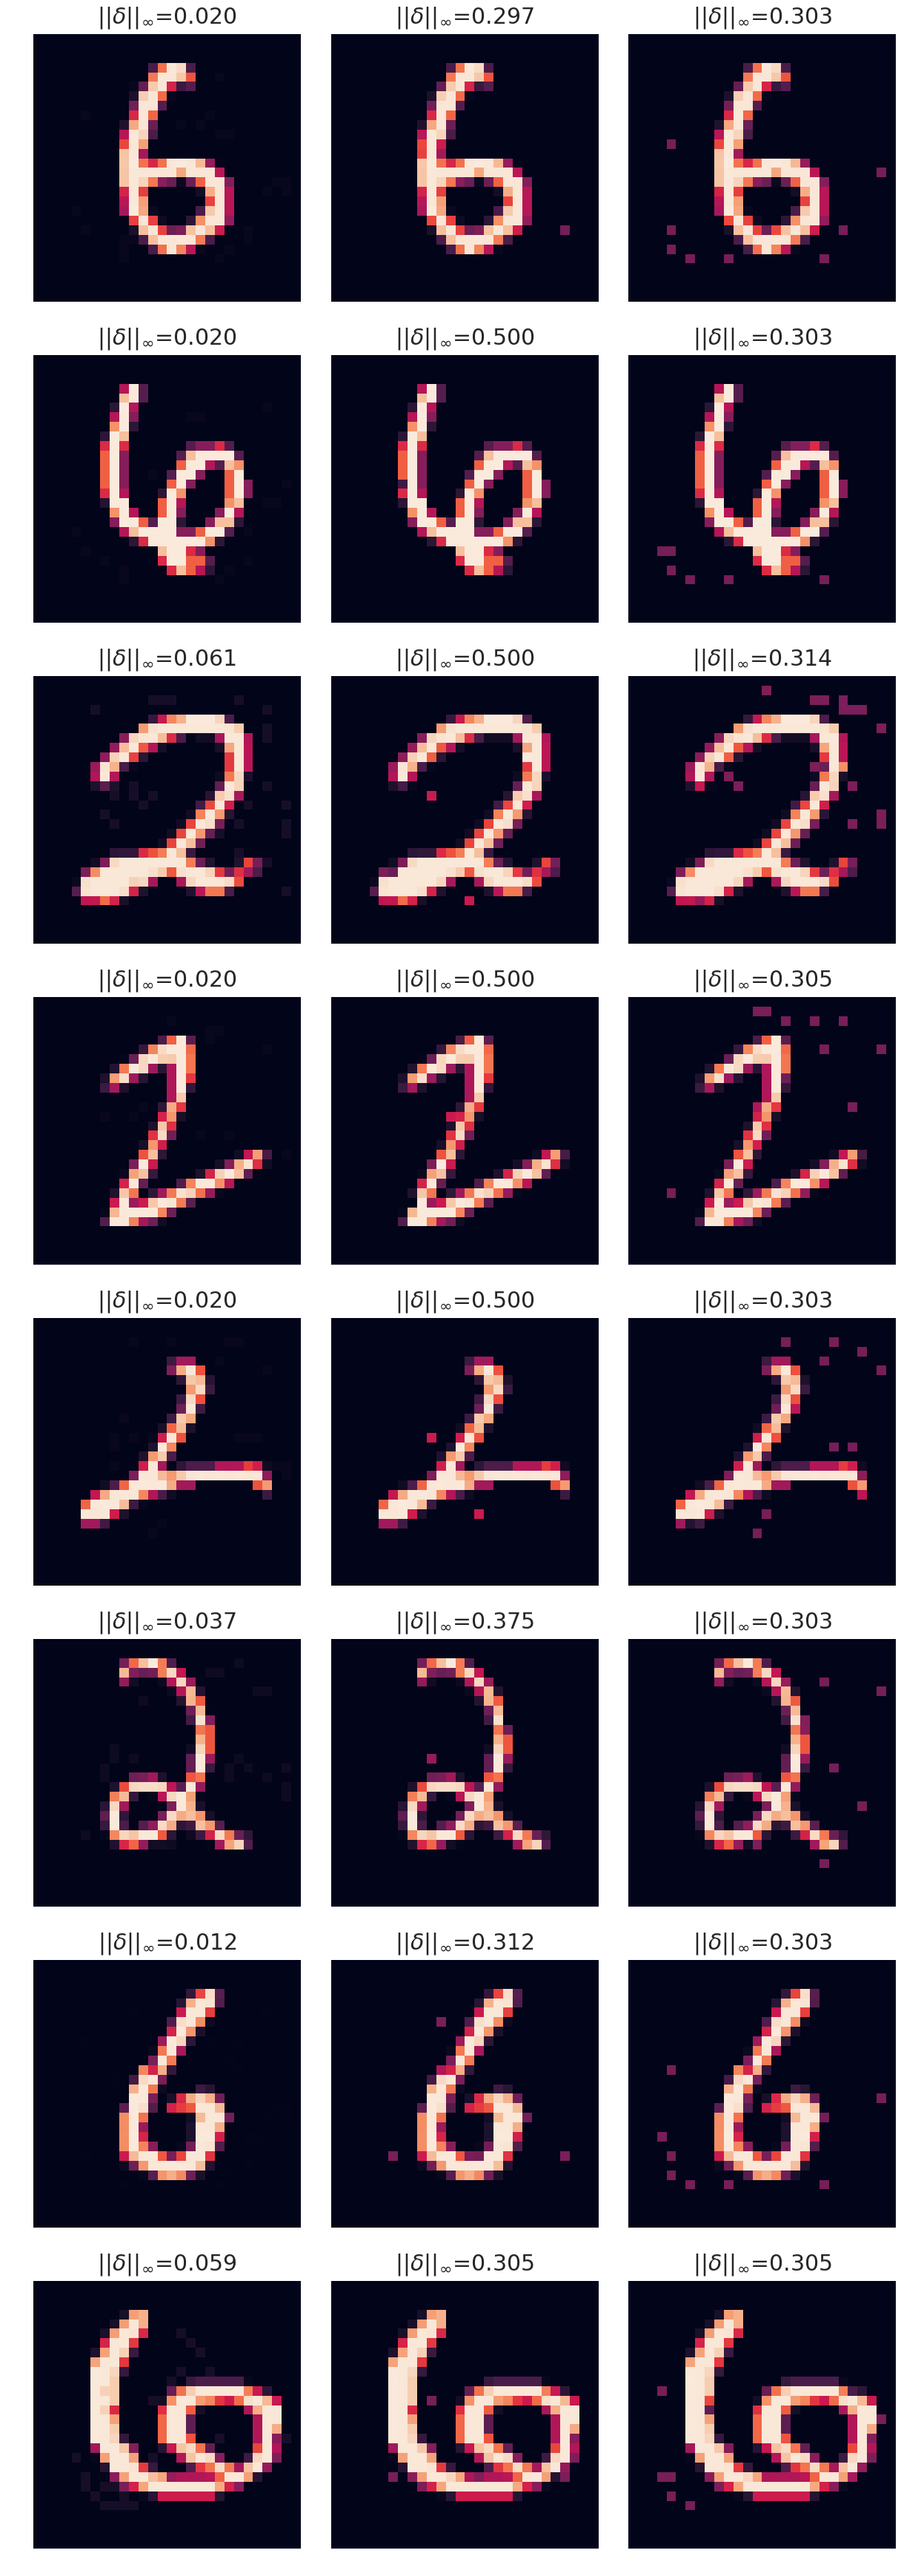

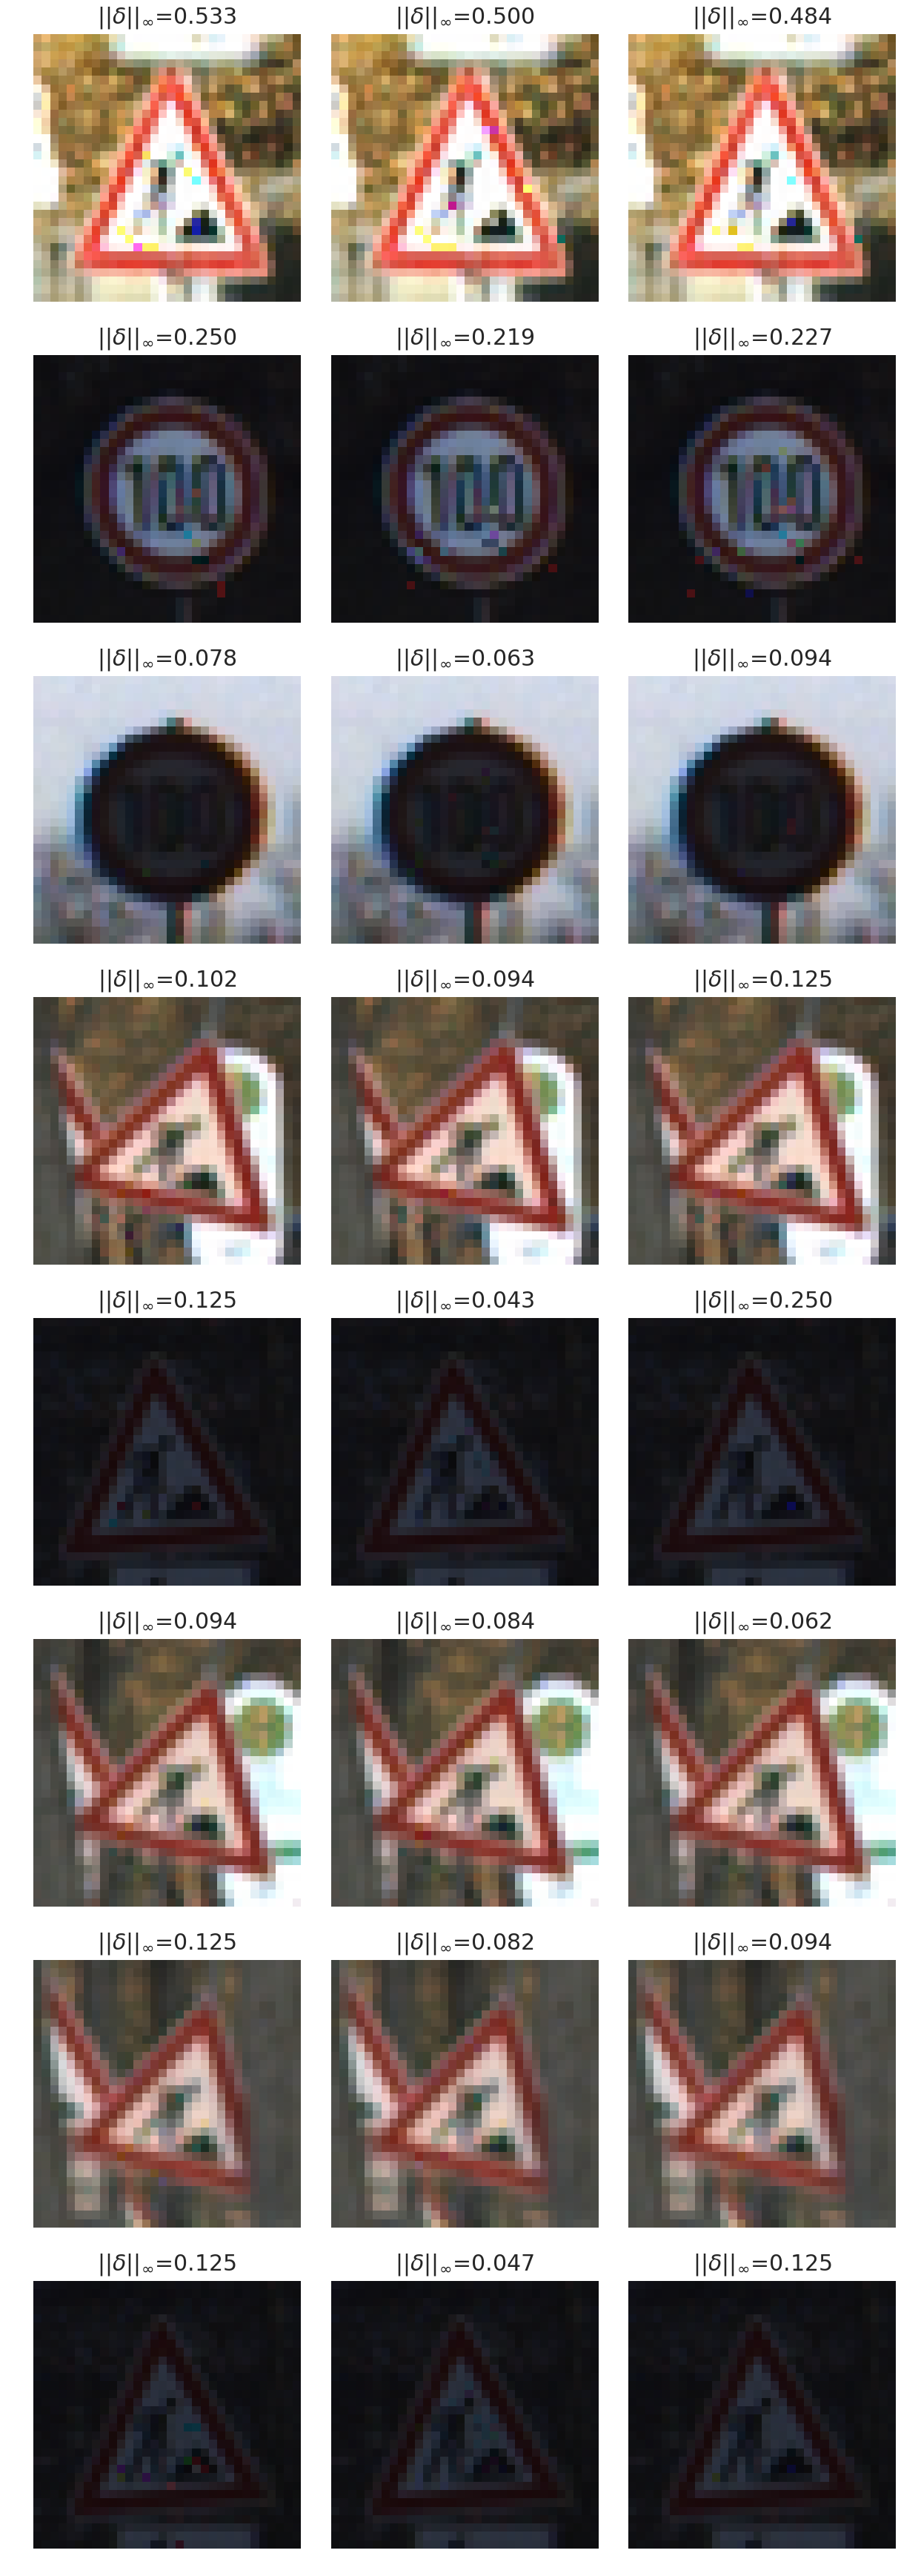

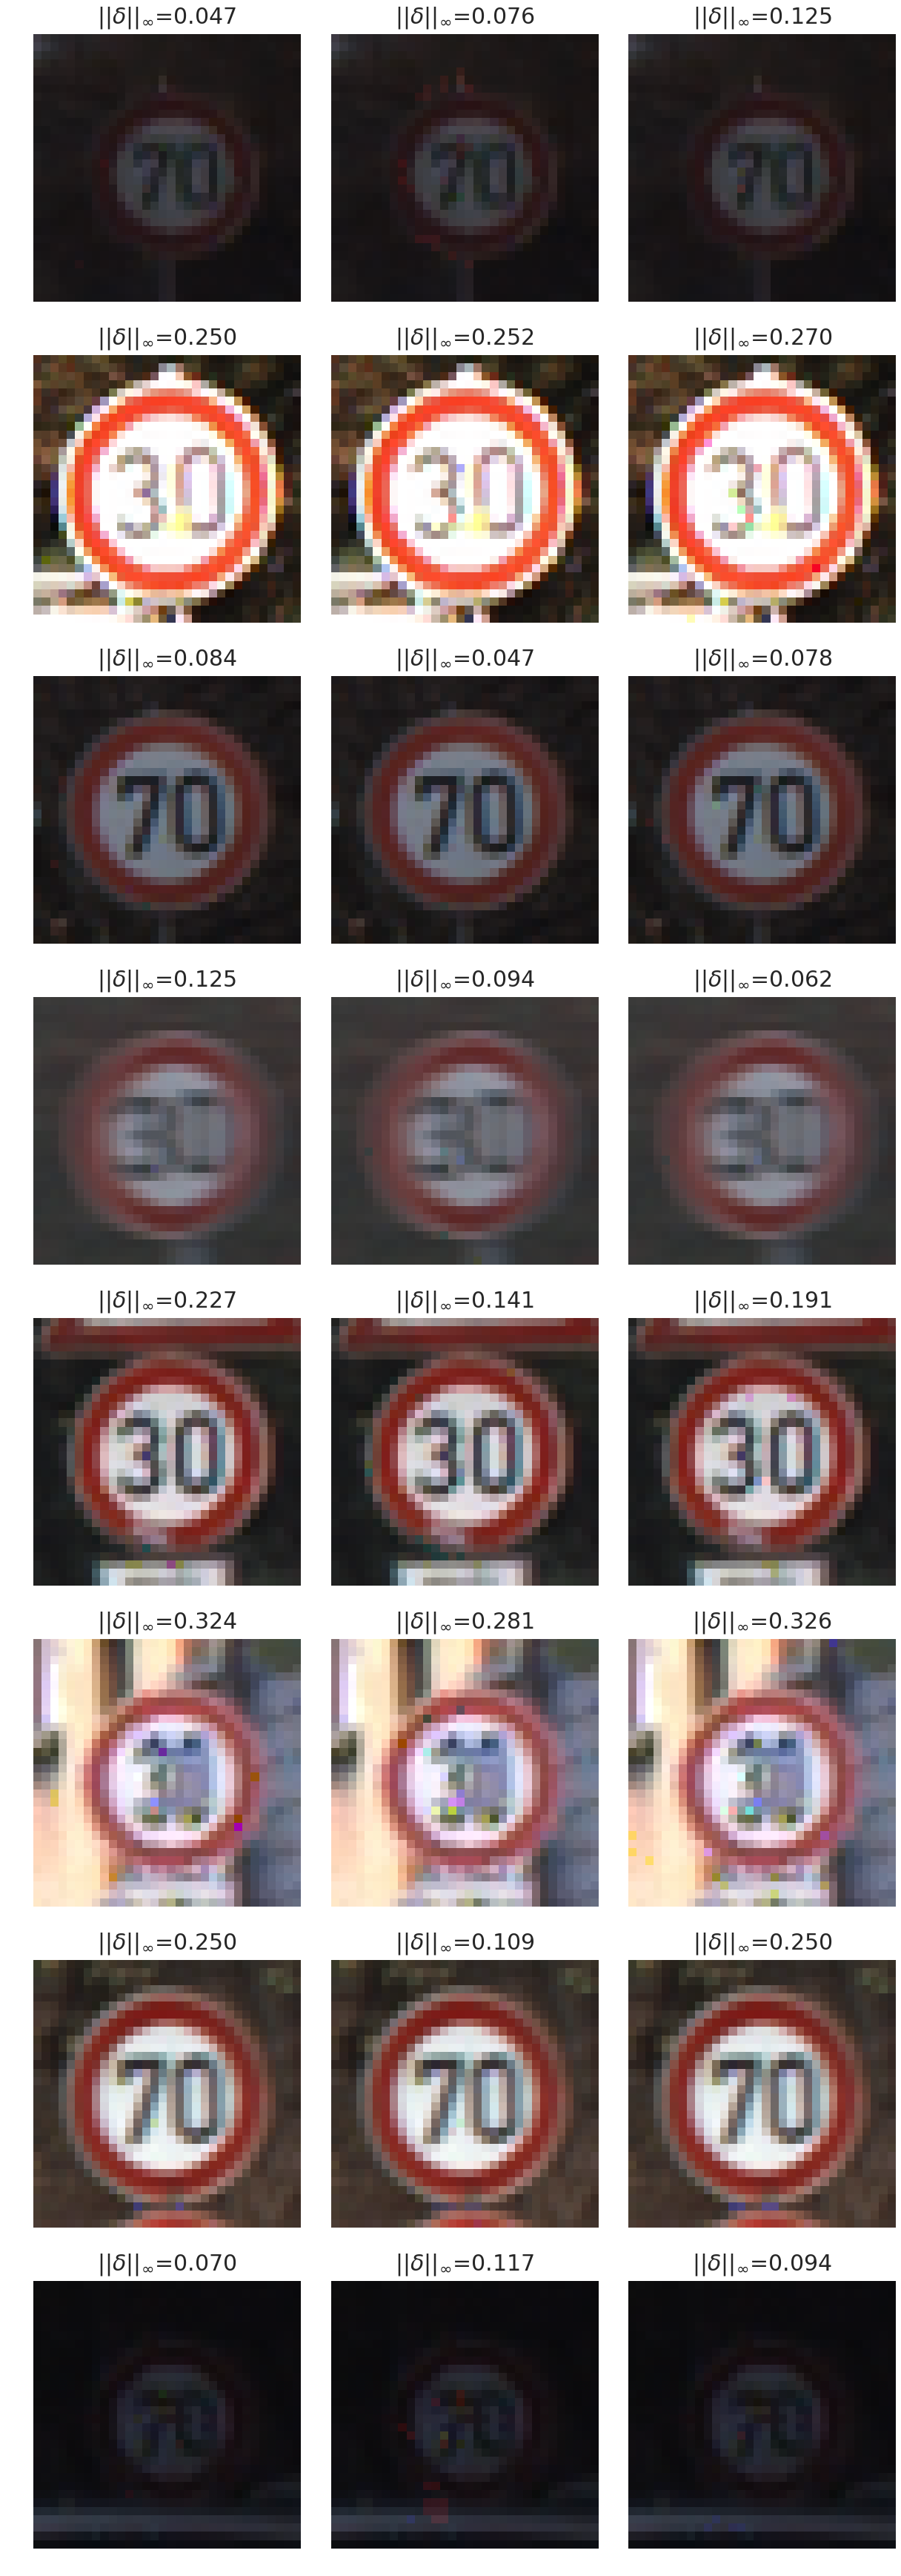

In [2]:
# datasets = ['breast_cancer', 'diabetes', 'cod_rna', 'mnist_1_5', 'mnist_2_6', 'fmnist_sandal_sneaker', 'gts_100_roadworks', 'gts_30_70']
datasets = ['mnist_1_5', 'mnist_2_6', 'gts_100_roadworks', 'gts_30_70']
# datasets = ['mnist_1_5']
for dataset in datasets:
    _, _, X_test, y_test, eps = data.all_datasets_dict[dataset]()
    if 'gts' in dataset:
        img_shape = (32, 32, 3)
    elif 'mnist' in dataset:
        img_shape = (28, 28)
    else:
        raise ValueError('wrong dataset for getting img_shape')
    
    np.random.seed(1)
    datasets = [dataset]
    models = ['plain', 'at_cube', 'robust_bound']
    # models = ['robust_bound']
    exp_folder = 'exps_diff_depth'
    weak_learner = 'tree'
    tree_depth = 4
    model_names = utils.get_model_names(datasets, models, exp_folder, weak_learner, tree_depth)
    
    n_trials_attack = 1000  # 1000 is quite slow
    idx_examples = np.arange(2, 10) if dataset != 'gts_100_roadworks' else np.array([0, 1, 2, 4, 6, 7, 8, 9])
    
    plot_height = 6
    sns.set(font_scale=2)
    fig_width = 1.3*len(model_names)*plot_height
    fig_height = 1.3*len(idx_examples)*plot_height
    
    fig, axs = plt.subplots(len(idx_examples), len(model_names), figsize=(fig_width, fig_height))    
    
    
    for i, model_name in enumerate(model_names):
        print('Model name: {}'.format(model_name))
        model = model_name.split('model=')[1].split(' ')[0]
        eps = model_name.split('eps=')[1].split(' ')[0]
        
        model_path = model_name + '.model.npy'
        metrics_path = model_name + '.metrics'
        metrics = np.loadtxt(exp_folder + '/' + metrics_path)
        valid_errs, valid_adv_errs = metrics[:, 8], metrics[:, 10]
        
        # Model selection
        # best_iter = len(valid_errs) - 1  # otherwise, the counts are not comparable between different model types
        if model == 'plain':
            best_iter = np.argmin(valid_errs)
        elif model in ['at_cube', 'robust_bound', 'robust_exact']:
            best_iter = np.argmin(valid_adv_errs)
        else:
            raise ValueError('wrong model name')
        print('Best iter to take the model: {}'.format(best_iter))
        
        if weak_learner == 'stump':
            # the hyperparameters of recreated models do not matter (they matter only for training)
            ensemble = StumpEnsemble(weak_learner, 0, 0, 0, 0, 0)
        elif weak_learner == 'tree':
            ensemble = TreeEnsemble(weak_learner, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        else:
            raise ValueError('wrong weak learner')
        model_ova = OneVsAllClassifier([ensemble])
        model_ova.load('{}/{}'.format(exp_folder, model_path), iteration=best_iter)
        
        # adversarial examples generation
        if weak_learner == 'stump':
            deltas = exact_attack_stumps(model_ova, X_test[idx_examples], y_test[idx_examples])
        elif weak_learner == 'tree':
            deltas = binary_search_attack(cube_attack, model_ova, X_test[idx_examples], y_test[idx_examples], n_trials_attack)
        else:
            raise ValueError('wrong weak learner')
    
        for i_idx, idx in enumerate(idx_examples):
            plot_name_short = '$||\delta||_\infty$={:.3f}'.format(np.abs(deltas[i_idx]).max())
            ax = axs[i_idx][i]
            ax.imshow((X_test[idx] + deltas[i_idx]).reshape(img_shape))
            ax.axis('off')
            ax.set_title(plot_name_short, fontsize=30, pad=15)
            print('')
    
    plot_name_save = 'adv_ex-exp={}-dataset={}-weak_learner={}'.format(
        exp_folder, dataset, weak_learner)
    # fig.tight_layout()
    fig.subplots_adjust(wspace=-0.2)
    plt.savefig('plots/{}.pdf'.format(plot_name_save), bbox_inches='tight',
                transparent=True)

